In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class LogisticRegression:
    def __init__(self,learning_rate=0.01,init_val=0.1):
        self.learning_rate=learning_rate
        self.init_val=init_val
    def fit(self,x_train,y_train,regularisation="normal",lamb=0,iterer=10000,stopper=0.01):
        dum_y = np.array(pd.get_dummies(y_train))
        params = {}
        for i,j in zip(range(dum_y.shape[1]),set(y_train)):
            weights = np.random.uniform(-self.init_val,self.init_val,size=(x_train.shape[1],))
            bias = np.random.uniform(-self.init_val,self.init_val,size=1)
            for _ in range(iterer):
                h0 = 1/(1+np.exp(-(np.dot(x_train,weights)+bias)))
                loss = h0.reshape(h0.shape[0])-dum_y[:,i]
                loss_std = loss/len(loss)
                if abs(round(np.sum(loss_std),2))==stopper:
                    break
                penaliser=0
                if regularisation.lower()=="lasso":penaliser = lamb*(np.sum(weights/np.absolute(weights)))
                elif regularisation.lower()=="ridge":penaliser = 2*lamb*np.sum(weights)
                weights = weights - self.learning_rate*(np.dot(x_train.T,loss_std)+penaliser)
                bias = bias - self.learning_rate*np.sum(loss_std)
                
            params[j] = [weights,bias]
        self.params_=params
    def predict(self,x_test):
        preder = []
        for i in self.params_:
            self.logit = np.dot(x_test,self.params_[i][0])+self.params_[i][1]
            self.probabs = np.exp(self.logit)/(1+np.exp(self.logit))
            preder.append(self.probabs)
        self.preder=np.array(preder).T
        der = []
        for i in range(self.preder.shape[0]):
            der.append(list(self.params_.keys())[self.preder[i,:].tolist().index(max(self.preder[i,:]))])
        return np.array(der)
    def roc_auc_curve(self,x_test,y_test,thresher=10,color="#FF7722",linewidth=3,figsize=(10,8)):
        sns.set()
        juj={}
        dum_yt = np.array(pd.get_dummies(y_test))
        for i,ret in zip(self.params_,range(dum_yt.shape[1])):
            tpr,fpr=[],[]
            for k in np.linspace(0,1,thresher):
                preds = []
                logit = np.dot(x_test,self.params_[i][0])+self.params_[i][1]
                probabs = np.exp(logit)/(1+np.exp(logit))
                for j in probabs:
                    preds.append(1 if j>=k else 0)
                preds = np.array(preds)
                tpr.append(round(len(preds[(dum_yt[:,ret]==1)&(preds==1)])/len(dum_yt[:,ret][dum_yt[:,ret]==1]),3))
                fpr.append(round(len(preds[(preds==1)&(dum_yt[:,ret]==0)])/len(dum_yt[:,ret][dum_yt[:,ret]==0]),3))
            juj[i]=[tpr,fpr]
        for i in juj:
            fuf=[]
            for j in range(len(juj[i][1])-1):
                fuf.append((juj[i][1][j+1]-juj[i][1][j])*(juj[i][0][j+1]+juj[i][0][j]))
            auc = -sum(fuf)/2
            plt.figure(figsize=figsize)
            plt.plot(juj[i][1],juj[i][0],color=color,linewidth=linewidth)
            plt.title(f"ROC-AUC Curve: Class {i}",fontsize=15)
            plt.ylabel("True Positive Rate (TPR)")
            plt.xlabel("False Positive Rate (FPR)")
            plt.text(0.85,0.1,f"AUC: {round(auc,3)}",
                     bbox=dict(facecolor='white',edgecolor='black', boxstyle='round,pad=1'))
            plt.show()
    def confusion_matrix(self,y,y_preds,cmap=None,labels=None,annot=True,figsize=(10,8)):
        sns.reset_orig()
        t=[len(y_preds[(y_preds==j)&(y==i)]) for i in set(y) for j in set(y)]
        t = np.reshape(t,(len(set(y)),len(set(y))))
        label = labels if labels!=None else list(set(y))
        plt.figure(figsize=figsize)
        sns.heatmap(t,cmap=cmap,annot=annot,
                    xticklabels=label,yticklabels=label)
        plt.yticks(rotation=0)
        plt.ylabel("True Labels")
        plt.xlabel("Predicted Labels")
        return plt.show()
    def classification_report(self,y,y_preds,labels=None):
        self.accuracy = (np.sum(y_preds==y)/len(y)).round(2)
        self.precision,self.recall,self.f1=[],[],[]
        for i in set(y):
            prec = round((len(y_preds[(y_preds==i)&(y==i)])/len(y_preds[y_preds==i])),2)
            rec = round((len(y_preds[(y_preds==i)&(y==i)])/len(y[y==i])),2)
            self.precision.append(prec)
            self.recall.append(rec)
            self.f1.append(round((2*prec*rec)/(prec+rec),2))
        self.precision,self.recall,self.f1 = np.array(self.precision),np.array(self.recall),np.array(self.f1)
        class_rep = pd.DataFrame()
        class_rep["Precision"]=self.precision
        class_rep["Recall"] = self.recall
        class_rep["F1-Score"] = self.f1
        class_rep["Support"] = [len(y[y==i]) for i in set(y)]
        class_rep.loc[len(class_rep.index)] = ["","",self.accuracy,len(y)]
        class_rep.loc[len(class_rep.index)] = [self.precision.mean().round(2),self.recall.mean().round(2),
                                               self.f1.mean().round(2),len(y)]
        label = labels if labels!=None else list(set(y))
        label.extend(["Accuracy","Average"])
        class_rep.index=label
        return class_rep

## Iris Dataset

In [28]:
iris = pd.read_csv("Iris-Dataset.csv")
d = {j:i for i,j in enumerate(iris["y"].unique())}
iris["y"] = [d[i] for i in iris["y"]]

### Randomisation

In [29]:
x,y = np.array(iris.drop(iris.columns[-1],axis=1)),np.array(iris[iris.columns[-1]])
indes = np.arange(0,len(x))
random.shuffle(indes)
x = x[indes]
y = y[indes]

### Train-Test Split

In [30]:
test_size = 0.2

In [31]:
x_train,y_train = x[:int(len(x)*(1-test_size))], y[:int(len(x)*(1-test_size))]
x_test,y_test = x[int(len(x)*(1-test_size)):], y[int(len(x)*(1-test_size)):]

### Standardisation

In [32]:
for i in range(x_train.shape[1]):
    x_train[:,i] = (x_train[:,i]-x_train[:,i].mean())/np.std(x_train[:,i])
    x_test[:,i] = (x_test[:,i]-x_test[:,i].mean())/np.std(x_test[:,i])

### Iris Modeling

In [33]:
iris_reg = LogisticRegression(0.01,0.1)

In [34]:
iris_reg.fit(x_train,y_train)

In [35]:
iris_preds = iris_reg.predict(x_test)

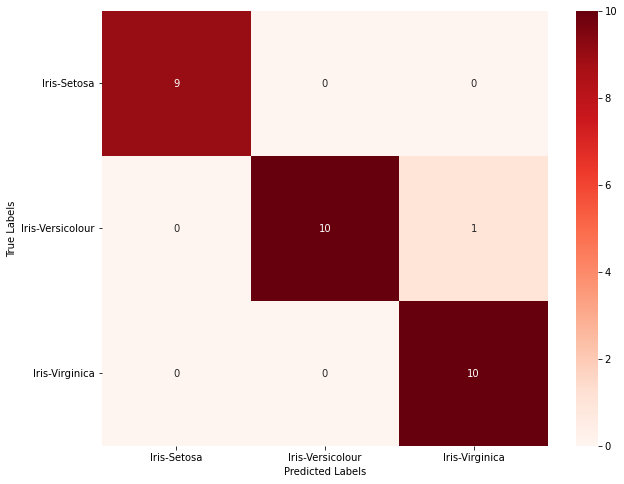

In [36]:
iris_reg.confusion_matrix(y_test,iris_preds,cmap="Reds",annot=True,labels=list(d.keys()),
                          figsize=(10,8))

In [37]:
iris_reg.classification_report(y_test,iris_preds,labels=list(d.keys()))

,Precision,Recall,F1-Score,Support
Iris-Setosa,1.0,1.0,1.00,9.0
Iris-Versicolour,1.0,0.91,0.95,11.0
Iris-Virginica,0.91,1.0,0.95,10.0
Accuracy,,,0.97,30.0
Average,0.97,0.97,0.97,30.0


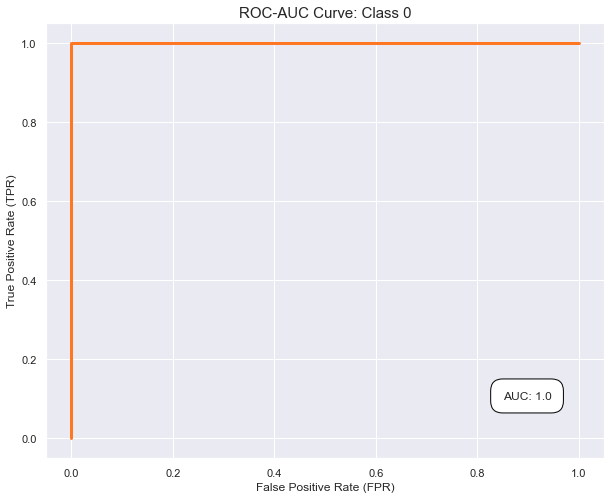

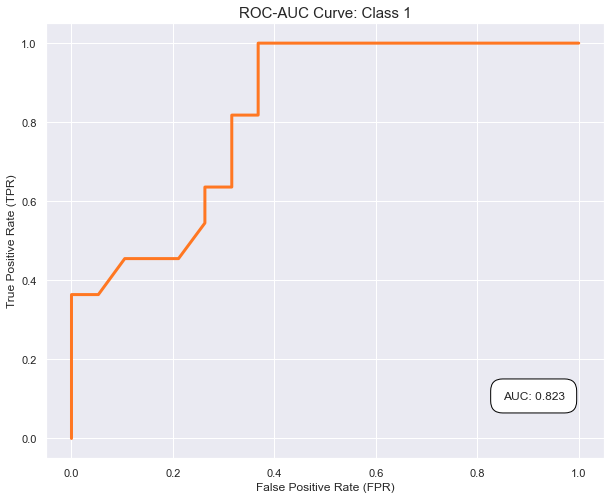

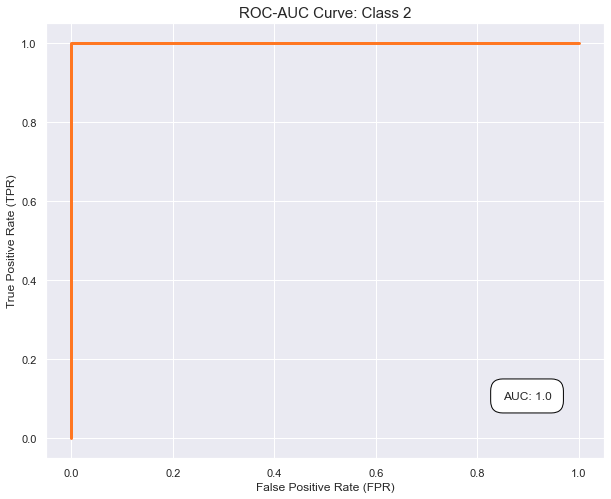

In [38]:
iris_reg.roc_auc_curve(x_test,y_test,thresher=100)

## MNIST Dataset

In [14]:
with np.load("mnist.npz") as data:
    x_train = data["training_images"]
    y_train = data["training_labels"]
    x_test = data["test_images"]
    y_test = data["test_labels"]
    v_x = data["validation_images"]
    v_y = data["validation_labels"]

### Merging Training and Validation Datasets

In [15]:
x_train = np.append(x_train,v_x,axis=0)
y_train = np.append(y_train,v_y,axis=0)

### Flattening Images

In [16]:
x_train = np.reshape(x_train,(60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

### Merging Dummies for Labels

In [17]:
y_t = []
for i in range(len(y_train)):
    y_t.append([i[0] for i in y_train[i]].index(1))
y_train = np.array(y_t)

In [18]:
y_tt = []
for i in range(len(y_test)):
    y_tt.append([i[0] for i in y_test[i]].index(1))
y_test = np.array(y_tt)

### MNIST Modeling

In [19]:
mnist_reg = LogisticRegression(0.01,0.1)

In [20]:
# Caution: Run this cell at your own risk, as it would consume lot of time and computation.
mnist_reg.fit(x_train,y_train,iterer=3000,stopper=0.01)

In [21]:
mnist_preds = mnist_reg.predict(x_test)

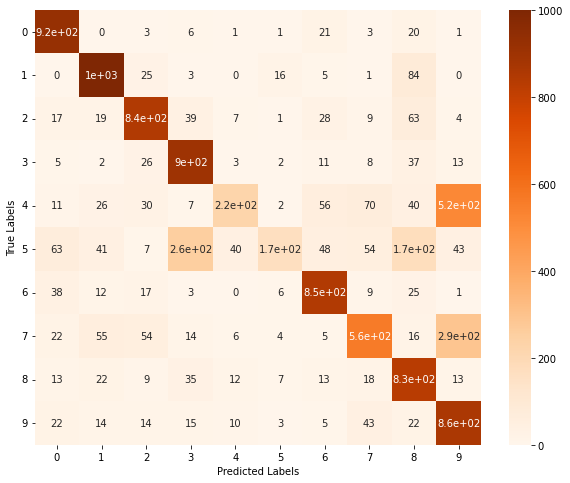

In [22]:
mnist_reg.confusion_matrix(y_test,mnist_preds,cmap="Oranges",annot=True,figsize=(10,8))

In [23]:
mnist_reg.classification_report(y_test,mnist_preds)

,Precision,Recall,F1-Score,Support
0,0.83,0.94,0.88,980.0
1,0.84,0.88,0.86,1135.0
2,0.82,0.82,0.82,1032.0
3,0.7,0.89,0.78,1010.0
4,0.74,0.23,0.35,982.0
5,0.8,0.19,0.31,892.0
6,0.82,0.88,0.85,958.0
7,0.72,0.55,0.62,1028.0
8,0.63,0.85,0.72,974.0
9,0.49,0.85,0.62,1009.0


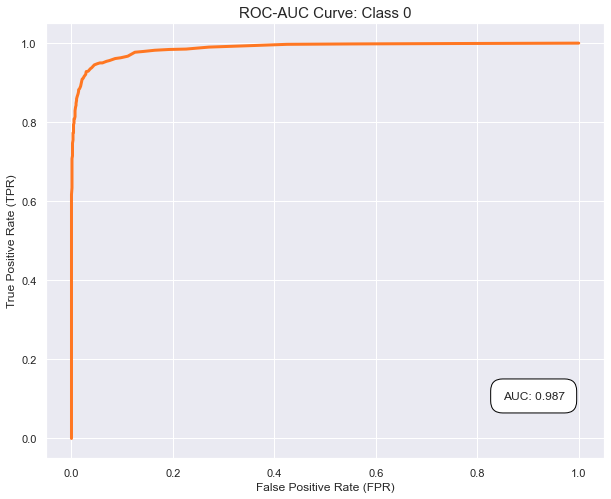

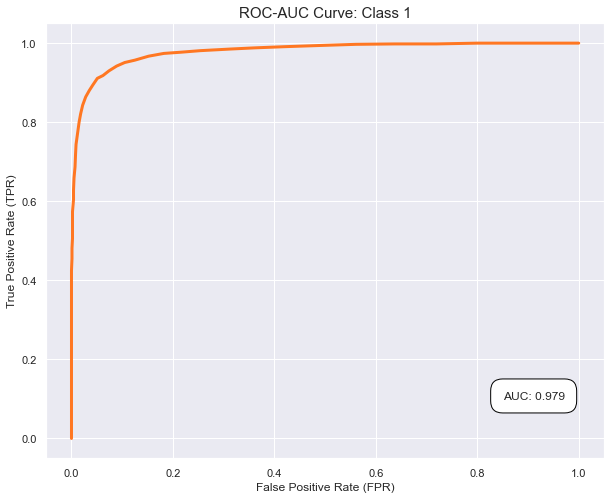

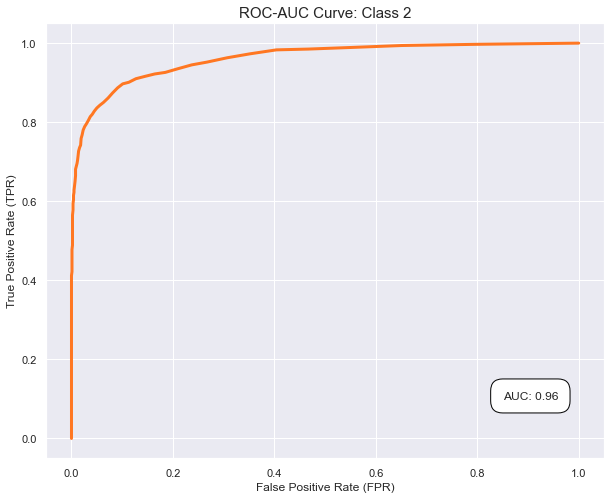

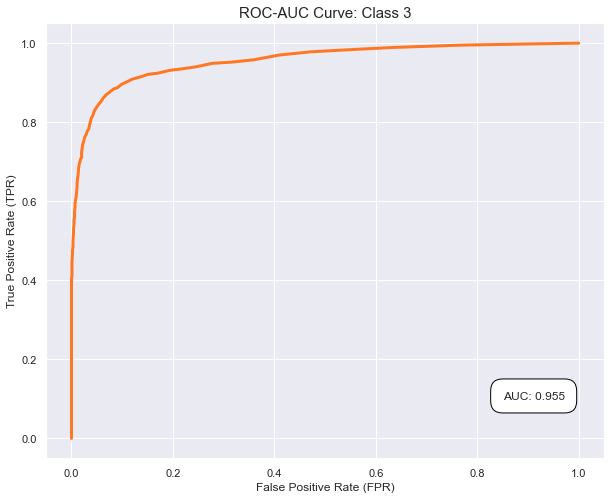

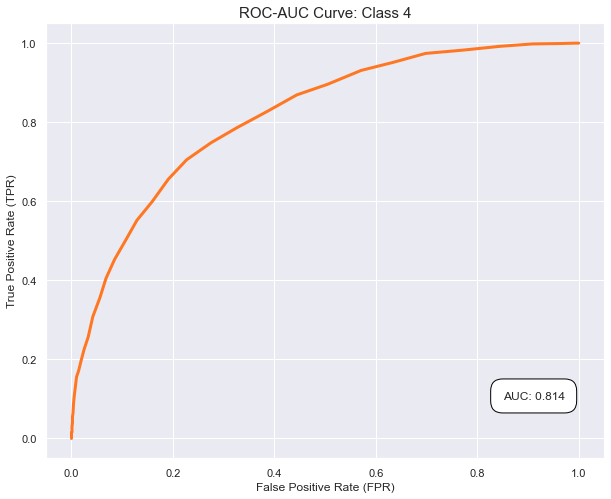

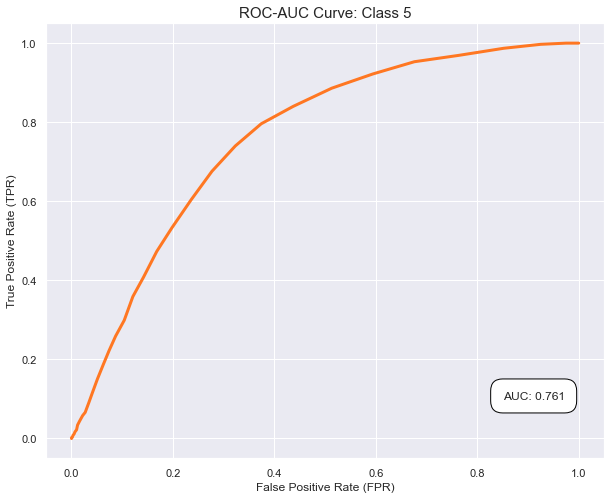

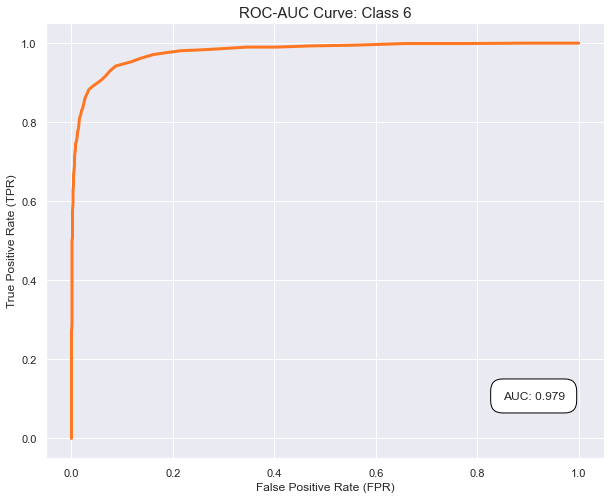

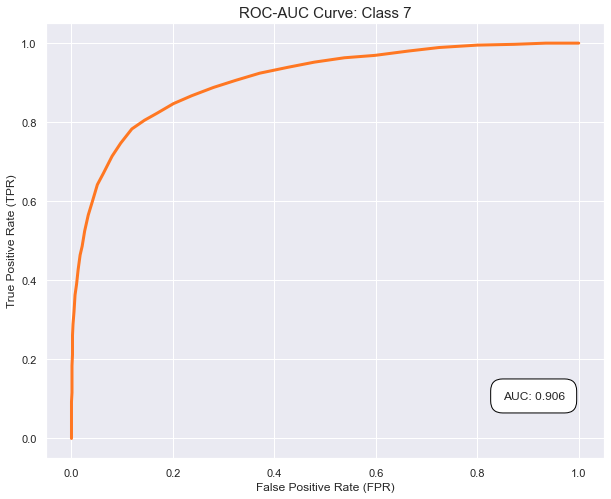

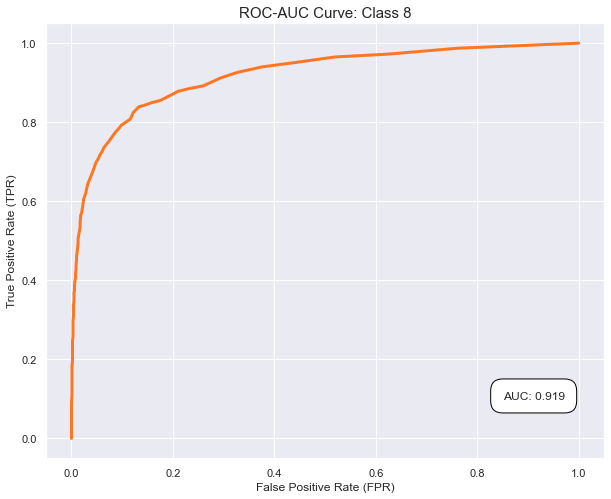

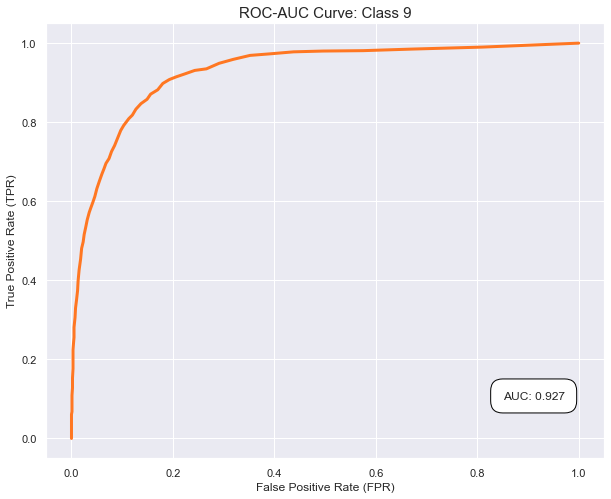

In [26]:
mnist_reg.roc_auc_curve(x_test,y_test,thresher=100)

In [39]:
"""
The accuracy would have been much more, but that would comsume a ton of time and computation power,
hence I allowed only 3000 iteration and that too with a stopping parameter that stops the iteration
when 0.01 average loss is achieved.
"""

'\nThe accuracy would have been much more, but that would comsume a ton of time and computation power,\nhence I allowed only 3000 iteration and that too with a stopping parameter that stops the iteration\nwhen 0.01 average loss is achieved.\n'